# Actividad 3

Especificaciones
1. Lee el dataset con un dataframe https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
2. Genera una gráfica tiempo vs numero de pasajeros.
3. Utiliza el 70% de los datos para entrenar y el 30% para hacer predicciones.
4. En una sola gráfica muestra los datos de entrenamiento y las predicciones.

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
import scipy
import torch

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv --quiet

In [4]:
# Read the dataset with a dataframe

from sklearn.preprocessing import MinMaxScaler
DF = pandas.read_csv('airline-passengers.csv')
training_set = pandas.read_csv('airline-passengers.csv')
training_set = training_set.iloc[ :, 1:2 ].values

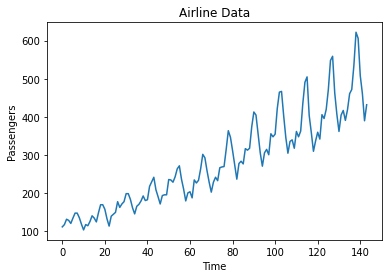

In [5]:
# Generate a time vs passengers plot

plt.plot(training_set)
plt.title('Airline Data', fontsize = 12)
plt.ylabel('Passengers')
plt.xlabel('Time')
plt.show()

In [8]:
# Use LSTM with a 0.3 testing size and 0.7 training size

# Preparing the Data
def sliding_windows(data, seq_length):
    X = []
    Y = []
    for dataPoint in range(len(data) - seq_length - 1):
        x = data[ dataPoint : ( dataPoint + seq_length )]
        y = data[ dataPoint + seq_length]
        X.append(x)
        Y.append(y)
    return numpy.array(X), numpy.array(Y)

# Scale the training data so that it fits the training set
# In this case it uses the default of 0 for min and 1 for max
scaleTheData = MinMaxScaler()
training_data = scaleTheData.fit_transform(training_set)

# Sequence Length is the how long each input vector is
# In this case it will use 3 data points advancing to the next one
# (1,2,3) then (2,3,4) then (3,4,5) ...
sequenceLength = 3

# The outputs will be the next expected datapoint in the sequence
# (4) then (5) then (6) ...
x, y = sliding_windows(training_data, sequenceLength)

# Training and Testing Size
# In this case since the output is 140 datapoints
# Then 70% for training will be 98 datapoints with 42 left for testing
trainingSize = 0.7
train_size = int(len(y) * trainingSize)
test_size = len(y) - train_size

# Transform datapoints into tensors with automatic gradients
# Also adjust the size of the training and testing sets
dataX = torch.autograd.Variable(torch.Tensor(numpy.array(x)))
dataY = torch.autograd.Variable(torch.Tensor(numpy.array(y)))
trainX = torch.autograd.Variable(torch.Tensor(numpy.array(x[0:train_size])))
trainY = torch.autograd.Variable(torch.Tensor(numpy.array(y[0:train_size])))
testX = torch.autograd.Variable(torch.Tensor(numpy.array(x[train_size:len(x)])))
testY = torch.autograd.Variable(torch.Tensor(numpy.array(y[train_size:len(y)])))

# Create LSTM Neural Network Model
class LSTM(torch.nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        h_0 = torch.autograd.Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = torch.autograd.Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # Propagate the input through the LSTM model
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

# Instance of the Model

numberOfClasses = 1
inputSize = 1
hiddenLayerSize = 2
numberOfLayers = 1
learningRate = 0.01

lstmInstance = LSTM(numberOfClasses, inputSize, hiddenLayerSize, numberOfLayers, sequenceLength)

# Use Mean Squared Error for the Regression in the Model
criterionFunction = torch.nn.MSELoss()

# Using normal gradiant descent with a fixed learning rate (SGD)
# optimizerFunction = torch.optim.SGD(lstmInstance.parameters(), lr=learningRate)
# Using adaptative gradiant descent with a variable learning rate (ADAM)
optimizerFunction = torch.optim.Adam(lstmInstance.parameters(), lr=learningRate)

# TRAINING
numberOfEphocs = 2000
for epoch in range(numberOfEphocs):
    outputs = lstmInstance(trainX)
    optimizerFunction.zero_grad()
    loss = criterionFunction(outputs, trainY)
    loss.backward()
    optimizerFunction.step()

# TESTING
lstmInstance.eval()
trainingPredictions = lstmInstance(dataX)

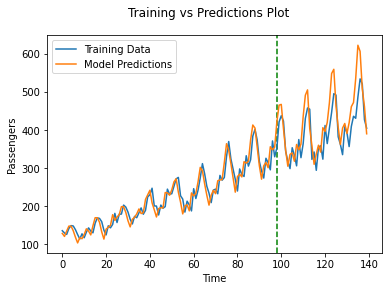

In [9]:
# Generate a training vs testing predictions plot

dataPredictions = dataY.data.numpy()
dataPredictionsPlot = scaleTheData.inverse_transform(dataPredictions)
modelPredictions = trainingPredictions.data.numpy()
modelPredictionsPlot = scaleTheData.inverse_transform(modelPredictions)
plt.axvline(x = train_size, c ='g', linestyle='--')
plt.plot(modelPredictionsPlot, label = 'Training Data')
plt.plot(dataPredictionsPlot, label = 'Model Predictions')
plt.legend(loc="upper left")
plt.suptitle('Training vs Predictions Plot')
plt.ylabel('Passengers')
plt.xlabel('Time')
plt.show()